### Replaced my model with Resnet model
### Added OneCycleLR, custom function for cropping, padding and cutout. (Yes these were there already in assignment 12)
### Horizontal flip of 0.5 implemented.
### Used Normalization values given in assignment.



## Description of blocks and strategy

- Defined the Resnet Block function which accepts input layer, channels size and kept strides size default to 1. So that i will pass stride size 2 for every first convolution in each block (except first block).
-  Did not used Maxpooling after first three times 3x3 convolution just to preserve the channels size.
-  Used 1x1 with strides 2 for making the channels size same and so for addition.

In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import keras
from keras.regularizers import l2
from keras import regularizers
from keras.datasets import mnist

Using TensorFlow backend.


In [0]:
cd /root/.keras/datasets/

/root/.keras/datasets


In [0]:
ls

cifar-10-batches-py/  cifar-10-batches-py.tar.gz


In [0]:
rm -rf cifar-10-batches-py

In [0]:
rm -rf cifar-10-batches-py.tar.gz

In [0]:
import numpy as np
import cv2
import keras
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback
from keras import optimizers

In [0]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


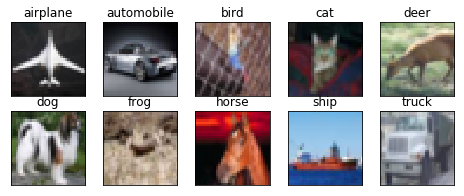

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def get_random_eraser_and_crop(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, random_crop_size=(32, 32), padding_for_crop=4,pixel_level=False):
  
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img
      
    def random_crop(input_img):
        
        # Note: image_data_format is 'channel_last'
        assert input_img.shape[2] == 3
        
        img = cv2.copyMakeBorder(input_img, padding_for_crop, padding_for_crop, padding_for_crop, padding_for_crop, cv2.BORDER_REPLICATE)
        
        height, width = img.shape[0], img.shape[1]
        
        dy, dx = random_crop_size
        
        x = np.random.randint(0, width - dx + 1)
        
        y = np.random.randint(0, height - dy + 1)
        
        return img[y:(y+dy), x:(x+dx), :]
      
    def do_preproc(input_image):
      
      return eraser(random_crop(input_image))
      
    return do_preproc

In [0]:
#Generator for training dataset.
datagen = ImageDataGenerator(horizontal_flip=0.5,featurewise_center=True, featurewise_std_normalization=True,preprocessing_function=get_random_eraser_and_crop(v_l=0,v_h=1))
datagen.mean = np.array([0.4914, 0.4822, 0.4465], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
datagen.std = np.array([0.2023, 0.1994, 0.2010], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
datagen.fit(train_features)
train_generator = datagen.flow(train_features,train_labels,batch_size=128,shuffle=False)
batchX, batchy = train_generator.next()
print(batchX.shape,batchX.mean(),batchX.std())

(128, 32, 32, 3) -0.030019887 1.0029794


In [0]:
#Generator for test dataset.
datagen_test = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen_test.fit(test_features)
test_generator = datagen_test.flow(test_features,test_labels,batch_size=128,shuffle=False)
batchX, batchy = test_generator.next()
print(batchX.shape,batchX.mean(),batchX.std())

(128, 32, 32, 3) -0.032796822 1.0182288


In [0]:
def ResNetBlock(input_layer,channels,stride=1):
  
  bn_1 = BatchNormalization()(input_layer)
  activation_layer_b1 = Activation('relu')(bn_1)
  block_layer_1 = Convolution2D(channels, (3,3), padding='same',strides=stride)(activation_layer_b1)
  
  bn_2 = BatchNormalization()(block_layer_1)
  activation_layer_b2 = Activation('relu')(bn_2) 
  block_layer_2 = Convolution2D(channels, (3,3), padding='same')(activation_layer_b2)
  
  return block_layer_2

In [0]:
from keras.layers import Input, add, GlobalAveragePooling2D, Dense
from keras.models import Model

inputs =Input(shape=(32, 32, 3))

x1 = Convolution2D(64, (3, 3),padding='same')(inputs)   #32x32 
activation_x1 = Activation('relu')(x1)

x2 = Convolution2D(64, (3, 3),padding='same')(activation_x1)   #32x32 
activation_x2 = Activation('relu')(x2)

x3 = Convolution2D(64, (3, 3),padding='same')(activation_x2)   #32x32 
activation_x3 = Activation('relu')(x3)


##block 1

blk1 = ResNetBlock(activation_x3,64)  ##32x32
z1 = add([blk1,activation_x3])

blk1_c = ResNetBlock(z1,64)
z1_c = add([blk1_c,z1])

##block 2

blk2 = ResNetBlock(z1_c,128,2)
one_blk = Convolution2D(128, (1, 1), padding='same',strides=2)(z1_c)
z2 = add([blk2,one_blk])

blk2_c = ResNetBlock(z2,128)
z2_c = add([blk2_c,z2])

##block3

blk3 = ResNetBlock(z2_c,256,stride=2)
one_blk_1 = Convolution2D(256, (1, 1), padding='same',strides=2)(z2_c)
z3 = add([blk3,one_blk_1])

blk3_c = ResNetBlock(z3,256)
z3_c = add([blk3_c,z3])

##block4

blk4 = ResNetBlock(z3_c,512,stride=2)
one_blk_2 = Convolution2D(512, (1, 1), padding='same',strides=2)(z3_c)
z4 = add([blk4,one_blk_2])

blk4_c = ResNetBlock(z4,512)
z4_c = add([blk4_c,z4])

avg_pool_layer = GlobalAveragePooling2D()(z4_c)

#flatten_layer = Flatten()(avg_pool_layer)

fc_layer = Dense(10, activation='softmax')(avg_pool_layer)


model1 = Model(inputs=inputs, outputs= fc_layer)

W0803 15:08:28.821366 140009141802880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 15:08:28.873123 140009141802880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 15:08:28.881746 140009141802880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0803 15:08:28.957955 140009141802880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0803 15:08:28.959233 1400091418

In [0]:
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   36928       activation_1[0][0]               
__________________________________________________________________________________________________
activation

In [0]:
# For retrieving the saved best results
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import numpy as np
import warnings

from keras.callbacks import Callback
from keras import backend as K


# Code is ported from https://github.com/fastai/fastai
class OneCycleLR(Callback):
    def __init__(self,
                 epochs,
                 batch_size,
                 samples,
                 steps,
                 max_lr,
                 end_percentage=0.1,
                 scale=100,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 verbose=True):
        """ This callback implements a cyclical learning rate policy (CLR).
        This is a special case of Cyclic Learning Rates, where we have only 1 cycle.
        After the completion of 1 cycle, the learning rate will decrease rapidly to
        100th its initial lowest value.
        # Arguments:
            max_lr: Float. Initial learning rate. This also sets the
                starting learning rate (which will be 10x smaller than
                this), and will increase to this value during the first cycle.
            end_percentage: Float. The percentage of all the epochs of training
                that will be dedicated to sharply decreasing the learning
                rate after the completion of 1 cycle. Must be between 0 and 1.
            scale_percentage: Float or None. If float, must be between 0 and 1.
                If None, it will compute the scale_percentage automatically
                based on the `end_percentage`.
            maximum_momentum: Optional. Sets the maximum momentum (initial)
                value, which gradually drops to its lowest value in half-cycle,
                then gradually increases again to stay constant at this max value.
                Can only be used with SGD Optimizer.
            minimum_momentum: Optional. Sets the minimum momentum at the end of
                the half-cycle. Can only be used with SGD Optimizer.
            verbose: Bool. Whether to print the current learning rate after every
                epoch.
        # Reference
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
            - [Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)
        """
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")


        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = scale
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = epochs
        self.batch_size = batch_size
        self.samples = samples
        self.steps = steps
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        """
        Compute the learning rate based on which phase of the cycle it is in.
        - If in the first half of training, the learning rate gradually increases.
        - If in the second half of training, the learning rate gradually decreases.
        - If in the final `end_percentage` portion of training, the learning rate
            is quickly reduced to near 100th of the original min learning rate.
        # Returns:
            the new learning rate
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            current_percentage = (self.clr_iterations - 2 * self.mid_cycle_id)
            current_percentage /= float((self.num_iterations - 2 * self.mid_cycle_id))
            new_lr = self.initial_lr * (1. + (current_percentage * (1. - 100.) / 100.)) / self.scale

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - (
                    self.clr_iterations - self.mid_cycle_id) / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage * (self.scale * 100 - 1.)) / self.scale

        else:
            current_percentage = self.clr_iterations / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage * (self.scale - 1.)) / self.scale

        if self.clr_iterations == self.num_iterations:
            self.clr_iterations = 0

        return new_lr

    def compute_momentum(self):
        """
         Compute the momentum based on which phase of the cycle it is in.
        - If in the first half of training, the momentum gradually decreases.
        - If in the second half of training, the momentum gradually increases.
        - If in the final `end_percentage` portion of training, the momentum value
            is kept constant at the maximum initial value.
        # Returns:
            the new momentum value
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            new_momentum = self.max_momentum

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - ((self.clr_iterations - self.mid_cycle_id) / float(
                self.mid_cycle_id))
            new_momentum = self.max_momentum - current_percentage * (
                    self.max_momentum - self.min_momentum)

        else:
            current_percentage = self.clr_iterations / float(self.mid_cycle_id)
            new_momentum = self.max_momentum - current_percentage * (
                    self.max_momentum - self.min_momentum)

        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))

In [0]:
lr_manager = OneCycleLR(samples=train_features.shape[0], epochs=10, batch_size=256,
                        steps=len(train_generator), max_lr=0.01,
                        end_percentage=0.1,
                        maximum_momentum=0.95, minimum_momentum=0.90)

In [0]:
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras import optimizers

In [0]:
model1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy']) 

W0803 15:09:49.213013 140009141802880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0803 15:09:49.248924 140009141802880 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Defining checkpoints
from keras.callbacks import ModelCheckpoint
filepath="/content/gdrive/My Drive/Raajesh-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
callbacks_list.append(lr_manager)

In [0]:
model1.fit_generator(
        train_generator,
        steps_per_epoch=np.ceil(50000/128),
        epochs=5,
        validation_data=test_generator,
        callbacks=callbacks_list,
        validation_steps=np.ceil(10000/128)) 

Epoch 1/5
391/391 [==============================] - 129s 330ms/step - loss: 0.2937 - acc: 0.9007 - val_loss: 0.2835 - val_acc: 0.8976

Epoch 00001: val_acc improved from -inf to 0.89760, saving model to /content/gdrive/My Drive/Raajesh-01-0.90.hdf5
 - lr: 0.00229 - momentum: 0.94 
Epoch 2/5
391/391 [==============================] - 123s 314ms/step - loss: 0.2489 - acc: 0.9060 - val_loss: 0.2516 - val_acc: 0.9069

Epoch 00002: val_acc improved from 0.89760 to 0.90694, saving model to /content/gdrive/My Drive/Raajesh-02-0.91.hdf5
 - lr: 0.00450 - momentum: 0.93 
Epoch 3/5
391/391 [==============================] - 122s 313ms/step - loss: 0.2283 - acc: 0.9120 - val_loss: 0.2118 - val_acc: 0.9163

Epoch 00003: val_acc improved from 0.90694 to 0.91627, saving model to /content/gdrive/My Drive/Raajesh-03-0.92.hdf5
 - lr: 0.00670 - momentum: 0.92 
Epoch 4/5
391/391 [==============================] - 122s 313ms/step - loss: 0.2078 - acc: 0.9188 - val_loss: 0.2266 - val_acc: 0.9144

Epoch 000

In [0]:
model1.load_weights('/content/gdrive/My Drive/Raajesh-84-0.97.hdf5')

In [0]:
score = model1.evaluate_generator(test_generator,steps=np.ceil(10000/128))
print(score)

[0.11735739028453827, 0.9723199969291687]


In [0]:
count = model1.predict_generator(test_generator,np.ceil(10000/128))
print(count.shape)

(10000, 10)


In [0]:
(Train_features, Train_labels),(Test_features,Test_labels) = cifar10.load_data()
train_features = train_features.astype('float32')/255
Test_features = Test_features.astype('float32')/255
predicted_classes = model1.predict_classes(Test_features)
Test_labels = Test_labels.reshape(10000,)
incorrect = np.nonzero(predicted_classes!=Test_labels)
arincorr = incorrect[0][0:25]

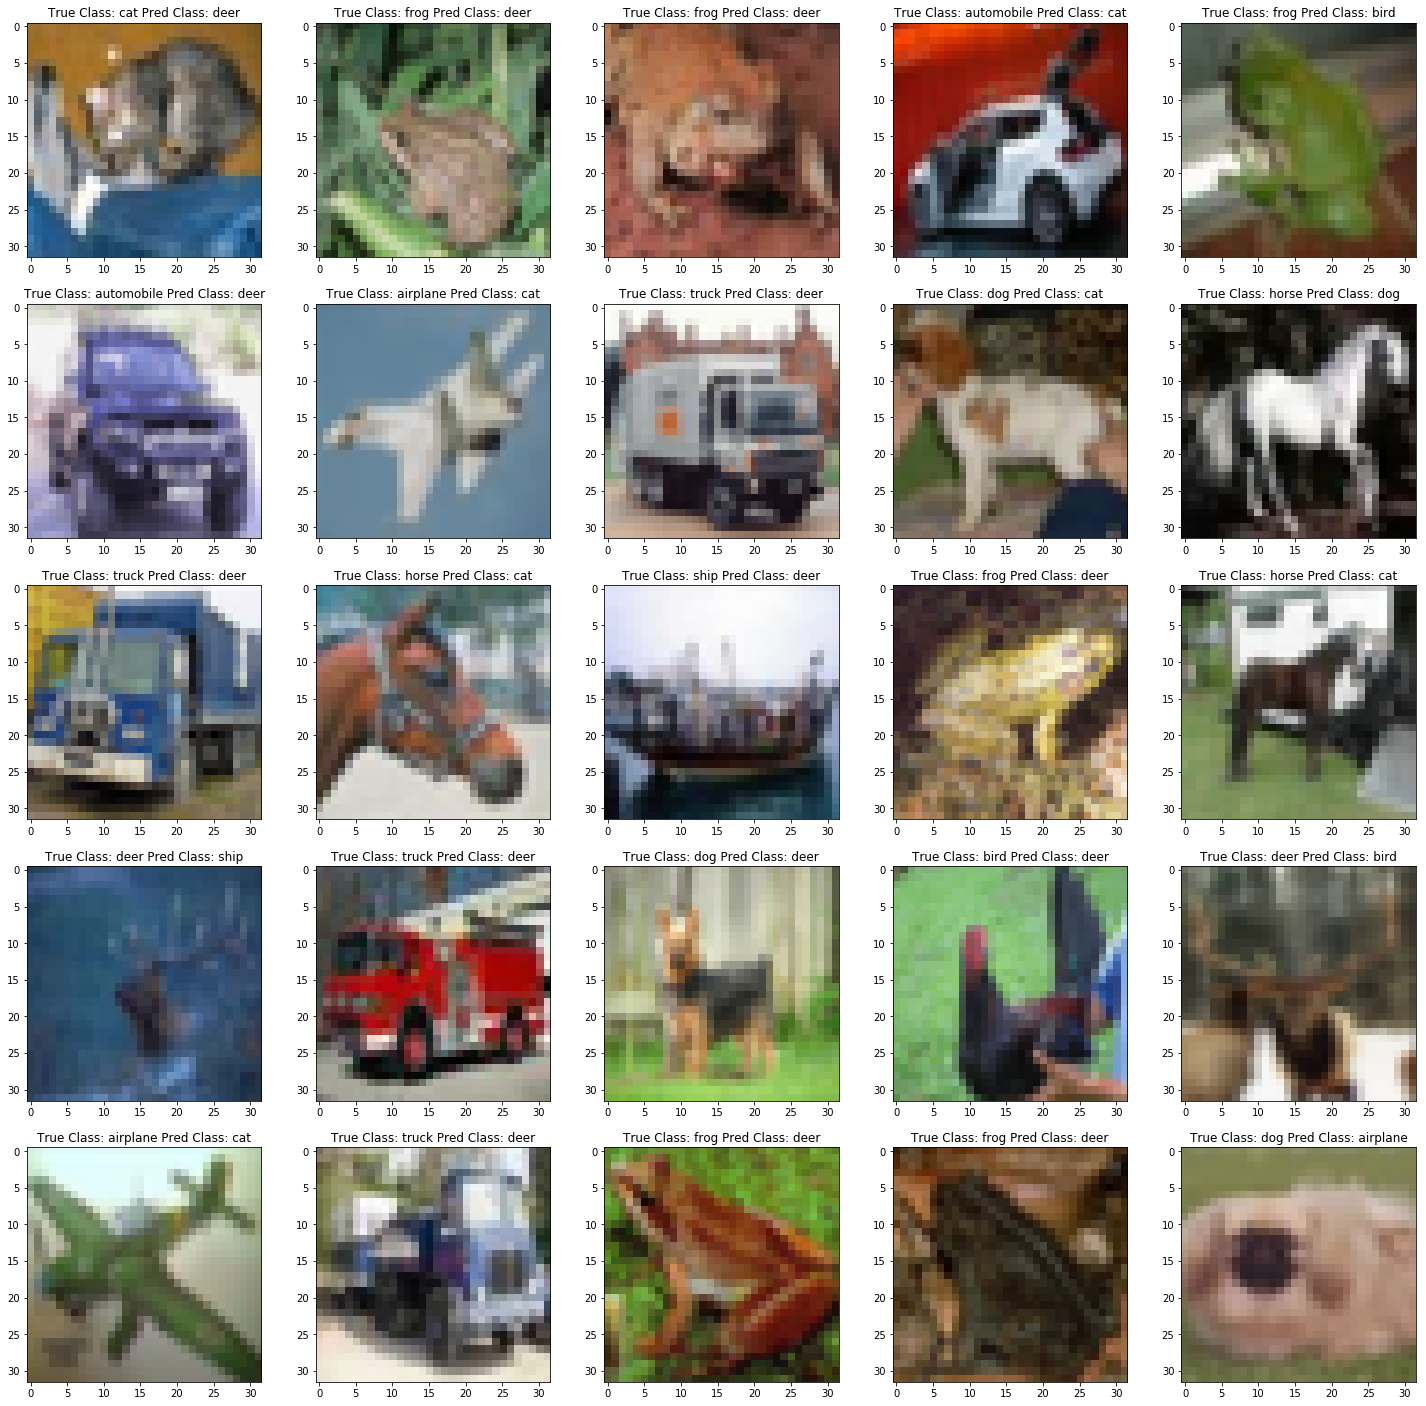

In [0]:
import matplotlib.pyplot as plt
import numpy as np

#plt.figure(0)
plt.figure(figsize = (25,25)) 
plots = []
count = 0
for i in range(5):
    for j in range(5):
        ax = plt.subplot2grid((5,5), (i,j))
        #print(arcorr[count])
        plt.imshow(Test_features[arincorr[count]].reshape(32,32,3),cmap='gray',interpolation='none')
        true = int(Test_labels[arincorr[count]])
        pred = int(predicted_classes[arincorr[count]])
        plt.title("True Class: "+str(class_names[true])+" Pred Class: " +str(class_names[pred]))
        #plt.title("Predicted {}, Class {}".format(predicted_classes[arcorr[count]], Test_labels[arcorr[count]]))
        count = count+1
plt.show()

In [0]:
(Train_features, Train_labels),(Test_features,Test_labels) = cifar10.load_data()

In [0]:
Train_features = Train_features.astype('float32')/255
Test_features = Test_features.astype('float32')/255

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

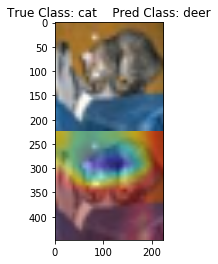

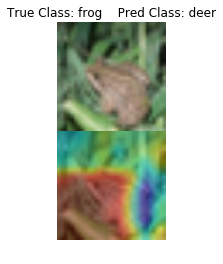

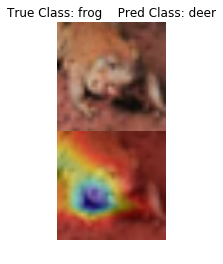

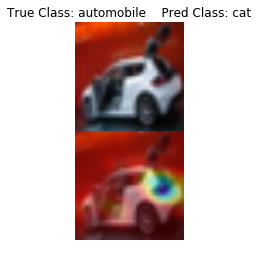

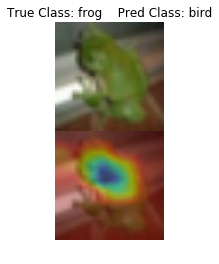

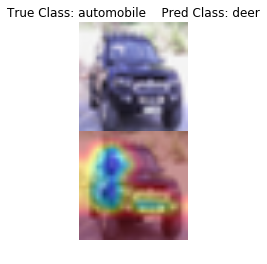

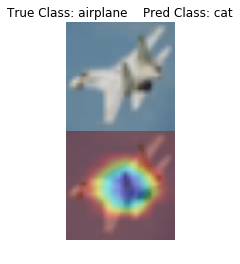

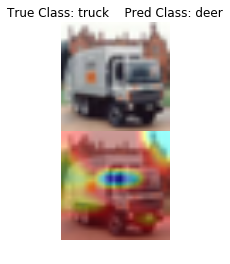

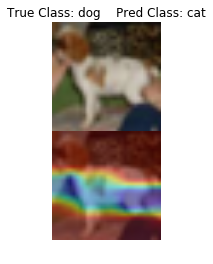

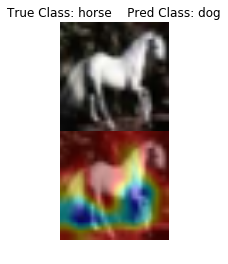

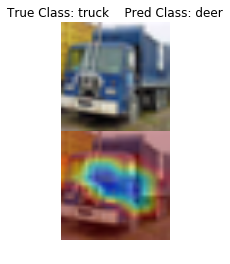

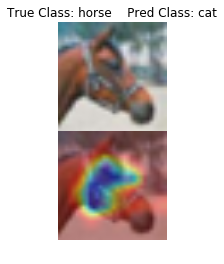

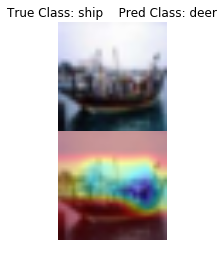

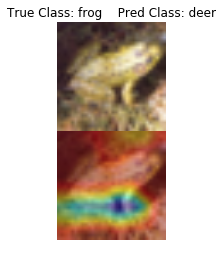

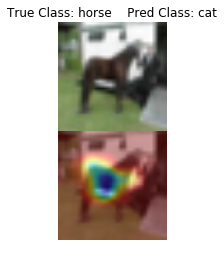

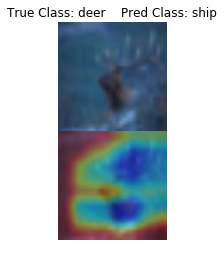

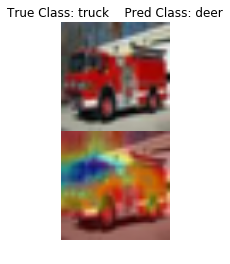

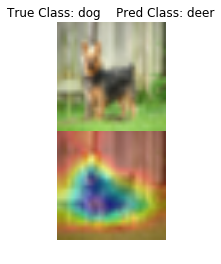

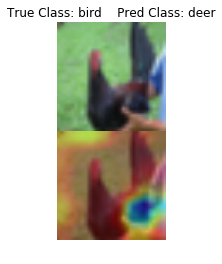

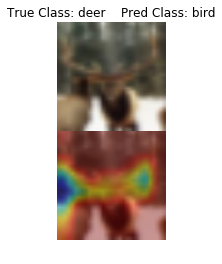

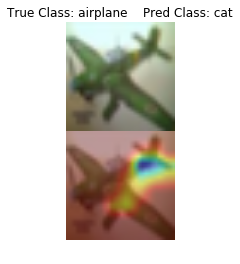

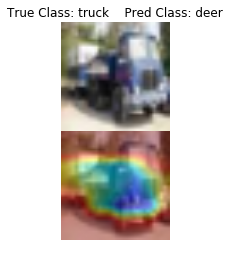

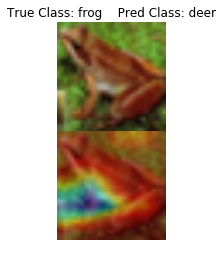

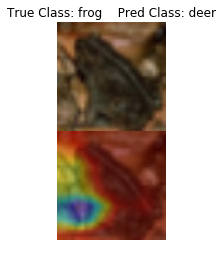

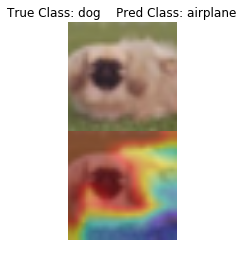

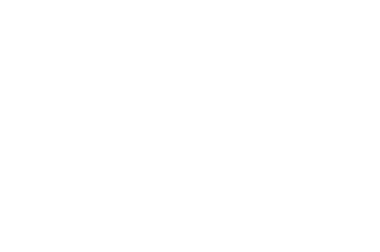

In [0]:
for n in arincorr:
  gradcam(n)

In [0]:
def gradcam(image_number):
  (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
  test_features = test_features.astype('float32')/255
  test_labels = np_utils.to_categorical(test_labels, num_classes)  
  img = test_features[image_number]
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  #x = preprocess_input(x)  
  preds = model1.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model1.output[:, class_idx]
  last_conv_layer = model1.get_layer("conv2d_8") 
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model1.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]    
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)  
  (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()  
  img = test_features[image_number]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  #from google.colab.patches import cv2_imshow
  img = cv2.resize(img,(224,224))
  superimposed_img = cv2.resize(superimposed_img,(224,224))
  #cv2_imshow(img)
  #cv2_imshow(superimposed_img)
  #cv2.waitKey(0)
  con = np.concatenate((img, superimposed_img), axis = 0)
  true = int(Test_labels[image_number])
  pred = int(predicted_classes[image_number])
  plt.title("True Class: " + str(class_names[true])+"    Pred Class: " + str(class_names[pred]))
  plt.imshow(con)
  plt.show()
  #plt.imshow(superimposed_img)
  #plt.title("predicted :",str(labels[predicted_classes[127]]))
  plt.axis('off')
  #plt.title("Predicted : " + labels[predicted_classes[image_number]], "True class : " + str(labels[Test_labels[image_number]])
  #plt.show()
  #cv2.waitKey(0)